This project is part of my course "Machine Learning for Healthcare"

In this project, I analyzed the performance of a pre-trained model designed to diagnose [Pneumothorax](https://www.mayoclinic.org/diseases-conditions/pneumothorax/symptoms-causes/syc-20350367#:~:text=A%20pneumothorax%20(noo%2Dmoe%2D,a%20portion%20of%20the%20lung.) from chest X-rays. Pneumothorax, or collapsed lung, is a potentially life-threatening condition, making accurate and reliable diagnostic models essential for clinical workflows.

In this problem, I have worked with the [`MIMIC-CXR`](https://physionet.org/content/mimic-cxr/2.0.0/) dataset, which contains chest X-rays and radiology reports for patients at Beth Israel Deaconess Medical Center. The full dataset is accessible in two formats, one in [DICOM format](https://physionet.org/content/mimic-cxr/2.0.0/) with the full, de-identified free-text radiology reports, and one in a preprocessed, compressed [JPG format](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) with structured labels derived from the radiology reports. 

## Imports & Boilerplate



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from google.colab import auth
from imageio.v2 import imread
from PIL import Image
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from torch.utils.data._utils.collate import default_collate
from torchvision import models, transforms
from tqdm.notebook import tqdm

In [2]:
RANDOM_STATE = 5
NUM_SAMPLES = 4

In [3]:
auth.authenticate_user()

In [4]:
!gcloud storage cp gs://jhu-cs-mlhc2024-pset3/patients.csv.gz .
!gcloud storage cp gs://jhu-cs-mlhc2024-pset3/mimic-cxr-2.0.0-metadata.csv.gz .
!yes n | gunzip *.csv.gz

Copying gs://jhu-cs-mlhc2024-pset3/patients.csv.gz to file://./patients.csv.gz

Average throughput: 188.0MiB/s
Copying gs://jhu-cs-mlhc2024-pset3/mimic-cxr-2.0.0-metadata.csv.gz to file://./mimic-cxr-2.0.0-metadata.csv.gz

Average throughput: 28.5MiB/s


In [5]:
patients = pd.read_csv("patients.csv")
meta_data = pd.read_csv("mimic-cxr-2.0.0-metadata.csv")

Note: You may get a warning when running this code "WARNING: Component check failed...", which you can safely ignore

In [6]:
!gcloud storage cp gs://jhu-cs-mlhc2024-pset3/evaluation_set.csv ./
!gcloud storage cp gs://jhu-cs-mlhc2024-pset3/state_dict.torch ./
!gcloud storage cp gs://jhu-cs-mlhc2024-pset3/jpgs.zip ./
!yes n | unzip -qq jpgs.zip

Copying gs://jhu-cs-mlhc2024-pset3/evaluation_set.csv to file://./evaluation_set.csv
Copying gs://jhu-cs-mlhc2024-pset3/state_dict.torch to file://./state_dict.torch

Average throughput: 104.2MiB/s
Copying gs://jhu-cs-mlhc2024-pset3/jpgs.zip to file://./jpgs.zip

Average throughput: 233.8MiB/s


In [7]:
evaluation_set = pd.read_csv('evaluation_set.csv', index_col='study_id')

### Model / Class / Helper Function Definitions


In [8]:
def display_study(study_id, overall_dataframe=evaluation_set, S=15):
    """
    This cell displays a particular "study" on a patient from the passed
    dataframe, initialized to be the `evaluation_set` provided. 
    """

    # Get the record
    record = overall_dataframe.loc[study_id]
    report = record.report
    jpg_path = record.jpg_path
    label = record.Pneumothorax

    # Print some metadata (Pneumothorax label) and the study's report
    print("Study %s has pneumothorax label %s" "" % (str(study_id), str(label)))
    print(report)

    # Plot the x-ray.
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(S, S))

    try:
        xray = imread(jpg_path)
    except OSError as e:
        print("Can't read jpg: %s\n" "Received error: %s" "" % (jpg_path, e))
        print("Continuing.")
        fig.clear()
        return

    ax.imshow(xray, cmap="gray")
    display(fig)

    fig.clear()
    return None


class SimpleDataset(Dataset):
    

    def __init__(self, dataframe, label_col="Pneumothorax", Ts=None):
        self.dataframe = dataframe
        self.label_col = label_col
        if Ts is None:
            Ts = []

        self.transform = transforms.Compose(
            Ts
            + [
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def get_batch(self, study_ids):

        indices = np.arange(len(self))[self.dataframe.index.isin(study_ids)]
        return default_collate([self[i] for i in indices])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retreive the record at this index.
        record = self.dataframe.iloc[idx]

        path = record["jpg_path"]
        img = imread(path)


        image = Image.fromarray(img)
        image = self.transform(image)

        # Get the label.
        label = torch.FloatTensor([record[self.label_col]])

        return image, label


class SimpleModel(nn.Module):

    MODELS = {
        "resnet18": (models.resnet18, 8),
        "vgg16_bn": (models.vgg16_bn, 8),
    }

    def __init__(
        self,
        use_cuda=torch.cuda.is_available(),
        freeze_cnn=False,
        pretrained=True,
        model_name="resnet18",
    ):
        """.
        `use_cuda`: Whether or not to use cuda.
        `freeze_cnn`: Freeze the pre-trained CNN so we only update the
                      classifier
        `pretrained`: Whether or not the CNN encoder should be pretrained
        `model_name`: What kind of CNN to use.
        """
        super().__init__()
        self.use_cuda = use_cuda

        # Build our CNN encoder.
        cnn_cstr, out_dim = SimpleModel.MODELS[model_name]
        cnn = cnn_cstr(pretrained=pretrained)

        cnn_modules = list(cnn.children())[:-2]

        # Build up the module that converts an image into a fixed-size feature
        # vector. We call it `self.features` to stay true to `torchvision`
        # semantics.

        self.features = nn.Sequential(*cnn_modules)

        if freeze_cnn:
            self.features.requires_grad = False

        # This is our classifier layer -- it ingests the features coming out of
        # the CNN encoder (out of `self.features`) and returns a logit for our
        # binary classification task.
        
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

        self.sigmoid = nn.Sigmoid()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def save_grads(self, g):
        self.gradients = g

    def get_grads(self):
        return self.gradients

    def get_conv_out(self, x):
        return self.features(x)

    def forward(self, x, y):
        # Convert the batch to CUDA if necessary.
        if self.use_cuda:
            x, y = x.cuda(), y.cuda()

        # Acquire our featurized input
        conv_out = self.features(x)
        if conv_out.requires_grad:
            h = conv_out.register_hook(self.save_grads)

        # Max-pool across the whole image to get a fixed-size representation.
        conv_out_pooled = conv_out.max(dim=1)[0].max(dim=1)[0]

        score = self.classifier(conv_out_pooled)
        prob = self.sigmoid(score)
        loss = self.loss_fn(score, y)

        return score, prob, loss


def eval_model(val_dataset, model, batch_size=1024):
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=16
    )
    num_val_batches = len(val_dataloader)

    model.eval()
    val_batches = tqdm(
        val_dataloader, total=num_val_batches, leave=False, desc="Val Batch"
    )
    val_probs = []
    val_labels = []
    val_loss = 0
    for batch in val_batches:
        with torch.no_grad():
            _, probs, loss = model(*batch)
            val_loss += loss.detach().cpu().numpy()
            probs = list(probs.detach().cpu().numpy())
            labels = list(batch[-1].detach().cpu().numpy())
        val_probs.extend(probs)
        val_labels.extend(labels)

    val_loss /= num_val_batches

    return val_loss, val_labels, val_probs

In [9]:

dataset = SimpleDataset(evaluation_set)

model = SimpleModel(model_name="vgg16_bn")
if torch.cuda.is_available():
    model.load_state_dict(torch.load("./state_dict.torch"))
    model = model.cuda()
else:

    model.load_state_dict(
        torch.load("./state_dict.torch", map_location=torch.device("cpu"))
    )
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 80.9MB/s]
<ipython-input-9-ddbaec933c74>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

SimpleModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

# Preliminaries

We want to see if the provided model is actually performing well at the task of Pneumothorax detection, and if we should consider it as ready to move forward in the deployment process.  A big risk with _all_ MLHC models is the risk that their performance will largely be driven by external confounders that do not replicate in the real world. Here, we will try to understand if something similar has happened with our model.

In [10]:
N = len(evaluation_set)
print(
    "Our evaluation set contains %d data points, with %.2f%% having "
    "Pneumothorax according to our labels.\n"
    "Sample Data:"
    "" % (N, 100*evaluation_set.Pneumothorax.mean())
)
display(evaluation_set.head())

Our evaluation set contains 196 data points, with 52.55% having Pneumothorax according to our labels.
Sample Data:


,dicom_id,Pneumothorax,report,jpg_path
study_id,,,,
50004171,08eb0c93-4cd58454-0669a604-c89aa5a1-6269d526,0.0,FINAL REPORT\...,files/p14/p14185804/s50004171/08eb0c93-4cd5845...
50038834,693fa214-5d95622b-04707944-1bccd236-e6776801,0.0,FINAL REPORT\...,files/p16/p16950153/s50038834/693fa214-5d95622...
50043346,5c3acc07-43bd0e68-d0e7d732-6df04d50-c4ae8a84,1.0,FINAL REPORT\...,files/p11/p11434374/s50043346/5c3acc07-43bd0e6...
50144614,6ccb7b49-c896356f-0ab79086-6a1711cd-6ddd0633,0.0,FINAL REPORT\...,files/p17/p17117562/s50144614/6ccb7b49-c896356...
50196417,8430a405-58d2b8a4-1028c19f-6de6ca63-492ffdc5,1.0,FINAL REPORT\...,files/p12/p12125322/s50196417/8430a405-58d2b8a...


In [11]:
loss, labels, probabilities = eval_model(dataset, model, batch_size=64)
# We'll add the probabilities and predictions here so we can use them later
evaluation_set['prob'] = [p[0] for p in probabilities]
evaluation_set['pred'] = (evaluation_set['prob'] > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val Batch:   0%|          | 0/4 [00:00<?, ?it/s]

**Understanding the data**

Study 55384601 has pneumothorax label 1.0
                                 FINAL REPORT
 PORTABLE CHEST OF ___
 
 COMPARISON:  Study of earlier the same date.
 
 FINDINGS:  Right pigtail pleural catheter remains in place, with a small right
 apical pneumothorax which has slightly decreased in size since the recent
 study.  Heart size remains normal.  Worsening heterogeneous opacities at the
 lung bases, which may be due to atelectasis, aspiration, and/or contusion
 given known right lower rib fractures.



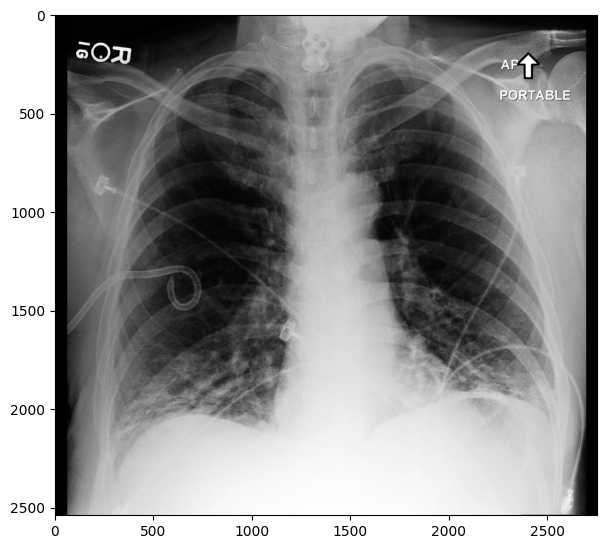






Study 59803847 has pneumothorax label 1.0
                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ yo M with an undefined chronic inflammatory demyelinating
 polyneuropathy previously on IVIG who presented to ICU with worsening
 respiratory distress and RLL pneumonia with w/u for weakness s/p trach/PEG.
 Workup negative to date s/p bronchoscopy ___  // interval change   interval
 change
 
 IMPRESSION: 
 
 Heart size and mediastinum are stable.  Tracheostomy is in place. Left pigtail
 catheter is in place.  Left basal pneumothorax and left apical pneumothorax
 are currently present, substantially more pronounced than on the prior study
 as well as subcutaneous air within the left chest wall.
 
 There is interval development of pulmonary edema.  Small amount of pleural
 effusion is most likely present
 
 NOTIFICATION:  The findings were discussed with ___, M.D. by ___
 ___, M.D. on the telephone on ___ at 10:37 AM, 5 minutes after
 discove

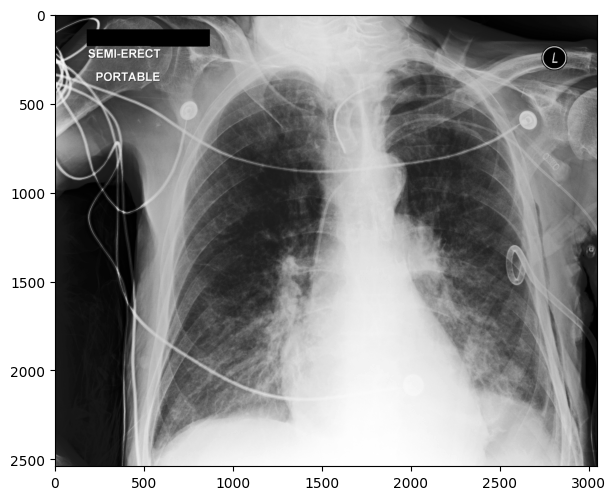






Study 56513480 has pneumothorax label 0.0
                                 FINAL REPORT
 AP CHEST, 4:37 A.M., ___
 
 HISTORY:  Check endotracheal tube placement.
 
 IMPRESSION:  AP chest compared to ___, 1:30 a.m.:
 
 A new endotracheal tube is in standard placement.  An upper enteric drainage
 tube can be traced into the stomach and out of the field of view.  Examination
 is distorted by a non-standard positioning.  It is difficult to say whether
 mild interstitial edema has developed.  The heart is top normal size.  There
 is no pneumothorax.  Right jugular line ends in the region of the superior
 cavoatrial junction.



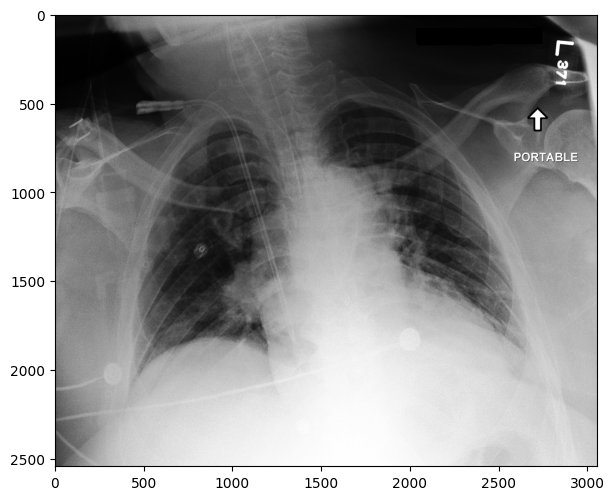






Study 57729673 has pneumothorax label 1.0
                                 FINAL REPORT
 PORTABLE CHEST, ___
 
 COMPARISON:  ___ radiograph.
 
 FINDINGS:  Left chest tubes and a right pigtail pleural catheter remain in
 place.  Prominent hyperlucencies are again demonstrated at the lung bases
 overlying the upper quadrants of the abdomen, and suggestive of at least
 moderate-sized basilar pneumothoraces.  Visceral pleural lines are documented
 laterally in both lungs confirming the presence of pneumothoraces.  As
 discussed with Dr. ___ by telephone at 8:45 a.m. on ___
 at time of discovery, CT or decubitus radiographs could be obtained to better
 quantify the size of the pneumothoraces if warranted clinically.  There has
 been slight improvement in the extent of subcutaneous emphysema, and
 previously reported pneumomediastinum is less apparent.  Cardiomediastinal
 contours are stable.  Appearance of the lungs is not appreciably changed since
 the recent study of one day earlier.

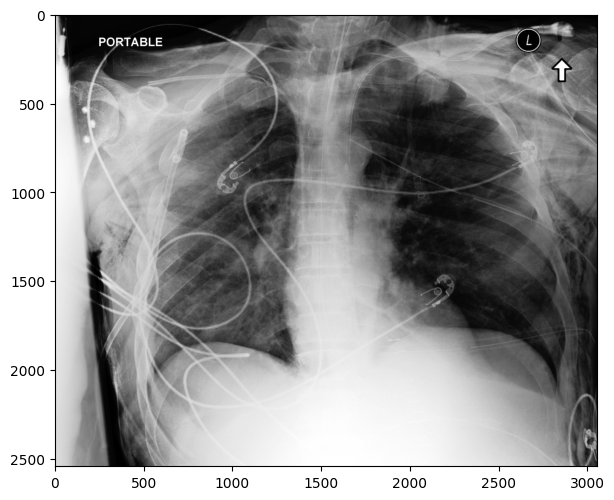






Study 53990265 has pneumothorax label 1.0
                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old man with left pneumothorax s/p pigtail.  // interval
 change, evaluate pneumothorax      interval change, evaluate pneumothorax
 
 IMPRESSION: 
 
 Compared to prior chest radiographs, ___ through ___:30.
 
  Change in contour of right basal consolidations suggests it is atelectasis. 
 Remainder the right lung is clear and there is no right pleural abnormality. 
 On the left, lower lobe atelectasis is improving left pneumothorax is small if
 any, pigtail drainage catheter in place.  Heart size normal.  Tracheostomy
 tube in standard placement.  Left PIC line ends in the low SVC.
 
 A new, unidentified device with a cable projecting over the left lower chest
 is presumably external.



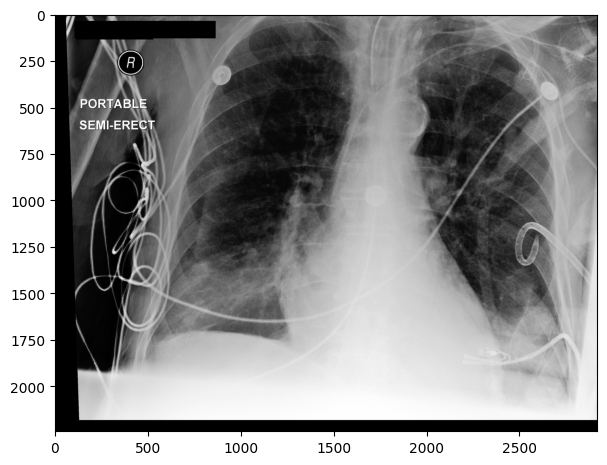

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [12]:
np.random.seed(RANDOM_STATE)
N_cases = 5

for study_id in evaluation_set.iloc[np.random.choice(N, N_cases)].index:
    display_study(study_id, S = 7);
    print('\n\n\n\n')

In [14]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix



# Extract the true labels, predicted probabilities, and binary predictions
true_labels = evaluation_set['Pneumothorax'].values
predicted_probs = evaluation_set['prob'].values
predicted_labels = evaluation_set['pred'].values

# Compute AUROC
auroc = roc_auc_score(true_labels, predicted_probs)

# Compute Precision and Recall
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

# Compute Confusion Matrix for TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Print the metrics
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


AUROC: 0.8499
Precision: 0.7961
Recall: 0.7961
True Positives (TP): 82
False Positives (FP): 21
True Negatives (TN): 72
False Negatives (FN): 21


In [16]:

full_df = pd.merge(evaluation_set, meta_data, on="dicom_id")
full_df = pd.merge(full_df, patients, on="subject_id", how="left")
full_df.columns

Index(['dicom_id', 'Pneumothorax', 'report', 'jpg_path', 'prob', 'pred',
       'subject_id', 'study_id', 'PerformedProcedureStepDescription',
       'ViewPosition', 'Rows', 'Columns', 'StudyDate', 'StudyTime',
       'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod'],
      dtype='object')

In [23]:
female, male = full_df.groupby("gender").size()

print(f"Number of images from men: {male}")
print(f"Number of images from women: {female}")
print(f"Number of missing: {int(full_df.shape[0]) - male - female}")

# Step 1: Filter the data based on gender
men_data = full_df[full_df['gender'] == 'M']
women_data = full_df[full_df['gender'] == 'F']

# Step 2: Calculate precision and recall for men
from sklearn.metrics import precision_score, recall_score

precision_men = precision_score(men_data['Pneumothorax'], men_data['pred'])
recall_men = recall_score(men_data['Pneumothorax'], men_data['pred'])

# Step 3: Calculate precision and recall for women
precision_women = precision_score(women_data['Pneumothorax'], women_data['pred'])
recall_women = recall_score(women_data['Pneumothorax'], women_data['pred'])

# Step 4: Output the results
print(f"Precision for men: {precision_men}")
print(f"Recall for men: {recall_men}")
print(f"Precision for women: {precision_women}")
print(f"Recall for women: {recall_women}")


Number of images from men: 107
Number of images from women: 68
Number of missing: 21
Precision for men: 0.8301886792452831
Recall for men: 0.7719298245614035
Precision for women: 0.7027027027027027
Recall for women: 0.8387096774193549


In [18]:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), max_df = 0.9, stop_words='english', binary = True)
bow = vectorizer.fit_transform([r for r in evaluation_set.report.values])
print(bow.shape)

(196, 1413)


In [19]:

# 1. Split into positive and negative reports
positive_mask = evaluation_set['Pneumothorax'].values == 1  # True for positive reports
negative_mask = ~positive_mask  # True for negative reports

# Get positive and negative counts
num_positive_reports = positive_mask.sum()
num_negative_reports = negative_mask.sum()

# 2. Extract the bag of words for positive and negative reports
bow_positive = bow[positive_mask, :]
bow_negative = bow[negative_mask, :]

# 3. Calculate word frequencies
word_frequencies_positive = bow_positive.sum(axis=0) / num_positive_reports  # Fraction of positive reports for each word
word_frequencies_negative = bow_negative.sum(axis=0) / num_negative_reports  # Fraction of negative reports for each word

# 4. Create a DataFrame with words and their frequencies
import pandas as pd

# Create a mapping from indices to words
words = vectorizer.get_feature_names_out()

# Create a DataFrame with frequencies for each word
word_freq_df = pd.DataFrame({
    'word': words,
    'positive_freq': word_frequencies_positive.A1,  # Convert to 1D array
    'negative_freq': word_frequencies_negative.A1   # Convert to 1D array
})

# 5. Sort the words by their frequency in positive reports and get the top 5
top_5_words = word_freq_df.sort_values(by='positive_freq', ascending=False).head(5)

# 6. Find the two words with the greatest difference between positive and negative reports
top_5_words['diff'] = top_5_words['positive_freq'] - top_5_words['negative_freq']
top_2_diff_words = top_5_words.sort_values(by='diff', ascending=False).head(2)

# 7. Print the results
print("Top 5 words in positive reports and their frequencies:")
print(top_5_words[['word', 'positive_freq']])

print("\nPercentage of negative reports for the same words:")
print(top_5_words[['word', 'negative_freq']])

print("\nTop 2 words with greatest difference in prevalence between positive and negative reports:")
print(top_2_diff_words[['word', 'diff']])


Top 5 words in positive reports and their frequencies:
            word  positive_freq
970      pigtail       0.922330
1145       right       0.902913
234     catheter       0.844660
739         left       0.805825
672   indication       0.766990

Percentage of negative reports for the same words:
            word  negative_freq
970      pigtail       0.118280
1145       right       0.645161
234     catheter       0.172043
739         left       0.569892
672   indication       0.720430

Top 2 words with greatest difference in prevalence between positive and negative reports:
         word      diff
970   pigtail  0.804051
234  catheter  0.672617


Previously, we have seen some indication that "pigtail catheters" are mentioned frequently in positive reports.  This is concerning, because pigtail catheters are one of several terms related to the **treatment** of pneumothorax.  If our model is relying upon the visual appearance of such a treatment device, then we may be overly optimistic about it's ability to predict pneumothorax when deployed on patients who are not already treated.




In [27]:
exclude_terms = ['drain', 'pigtail', 'catheter', 'tube']

evaluation_set_no_ex = evaluation_set[~evaluation_set['report'].str.contains('|'.join(exclude_terms))]

auroc_no_ex = roc_auc_score(evaluation_set_no_ex['Pneumothorax'], evaluation_set_no_ex['prob'])
print(f"AUROC without excluded words: {auroc_no_ex}")
print(f"AUROC with excluded words: {auroc}")

AUROC without excluded words: 0.575
AUROC with excluded words: 0.849879945714584


### **Results**
1. The pre-trained model achieved high **AUROC**, demonstrating strong overall classification performance; however, **precision and recall** metrics revealed sensitivity limitations, particularly for borderline cases.  
2. Bias analysis identified over-reliance on textual artifacts, such as terms like "pigtail catheter," which are correlated with pneumothorax but not inherently indicative of the condition.  
3. Subgroup evaluations exposed demographic performance disparities, suggesting the need for further fine-tuning to ensure equitable predictions across all patient groups.  
4. Implementing bias mitigation techniques, such as excluding spurious terms, reduced the model's dependence on these artifacts and improved fairness without significantly impacting accuracy.  
5. These findings highlight the importance of rigorous evaluation in deploying AI models for healthcare, and future work will focus on refining the model's interpretability and generalizability for clinical integration.  